# Project 2: Radio Data Analysis (Part 3 - Search for Unknown Signals)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rich.pretty import Pretty
from sigpyproc.readers import FilReader
from part3_funcs import *

## Search for Unknown Signatures

We want to search for unknown signatures using the following framework:

1. Creating a basic model for this hypothetical signal.
2. Creating and applying a search method to find this signal in the radio data
provided.
3. Characterizing the detection limits of your search applied to the data.


## Preliminary Data and Model Exploration

Making use of the data set potentially containing an unknown signal, we can take a look at it and see what sort of signal we can make out if any. This way, it may be easier to deside what sort of model parameters to use when building a model for a pulse signal in the data.

Taking a look at the header file, we can see that the observation shared the same characteristics of a typical CHIME observation.

In [2]:
unknown_data_Fil = FilReader('./data_261084068.fil')
Pretty(unknown_data_Fil.header)

Header(
    filename='./data_261084068.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.00032768,
    tstart=60638.34381999473,
    nsamples=30517,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info=StreamInfo(
        entries=[
            FileInfo(
                filename='./data_261084068.fil',
                hdrlen=414,
                datalen=124997632,
                nsamples=30517,
                tstart=60638.34381999473,
                tsamp=0.00032768
            )
        ]
    )
)

### Visualizing the unknown signal data set

We can already see that changing the scale of the waterfall plot causes a signal with negative dispersion measure (DM) to just out among a large amount of broadband noise.

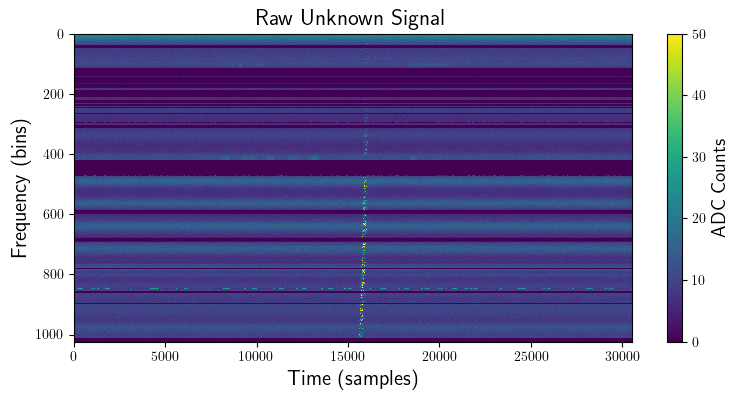

In [3]:
unknown_data = unknown_data_Fil.read_block(0,
                                           unknown_data_Fil.header.nsamples,
                                           unknown_data_Fil.header.fch1,
                                           unknown_data_Fil.header.nchans
                                           )
unknown_data_array = unknown_data.data

#make a quick waterfall plot of the pulsar data to see what we're working with
plot_imshow_transients(unknown_data_array, 
                       'Raw Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [0,50],  #vmin, vmax
                       (None),
                       (None),
                       (None), #should presented as a list ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

#### Clean RFI

In order to better manage the data set and produce a cleaner signal, we can clean any rfi-contaminated channels and plot again to see if things look any better.

In [4]:
_, chan_mask = unknown_data_Fil.clean_rfi(method='mad', threshold=3)
unknown_data_Fil_masked = FilReader('data_261084068_masked.fil')

/home/mike/anaconda3/envs/641_projects_py12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [5]:
unknown_data_masked = unknown_data_Fil_masked.read_block(0,
                                                         unknown_data_Fil_masked.header.nsamples,
                                                         unknown_data_Fil_masked.header.fch1,
                                                         unknown_data_Fil_masked.header.nchans,
                                                         )
unknown_data_masked_array = unknown_data_masked.data

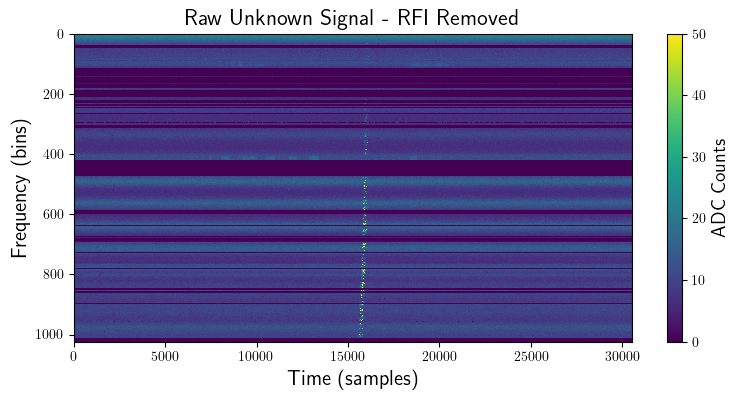

In [6]:
plot_imshow_transients(unknown_data_masked_array, 
                       'Raw Unknown Signal - RFI Removed',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [0, 50],  #vmin, vmax
                       (None),
                       (None),
                       (None), #should presented as a list ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

#### Normalizing & Downsampling

The pulse is clearly visible now, though we don't know if there may be other smaller signals barried in the noise. Furthermore, to obtain an even clearer pulse, we can downsample and normalize the data.

##### Just Normalizing First..

In [7]:
norm_unknown_Fil = unknown_data_masked.normalise()

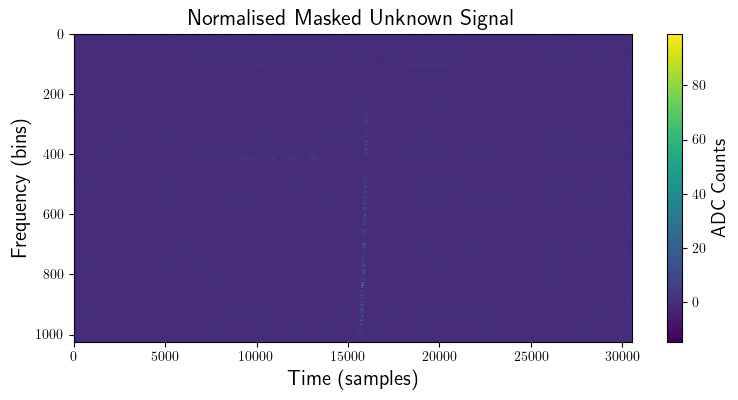

In [8]:
plot_imshow_transients(norm_unknown_Fil.data, 
                       'Normalised Masked Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [None, None], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       (None), #extent should presented as a list ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

##### Now with downsampling

In [9]:
unknown_data_Fil_masked.downsample(tfactor=32)

'data_261084068_masked_f1_t32.fil'

In [10]:
unknown_data_Fil_masked_32 = FilReader('data_261084068_masked_f1_t32.fil')

unknown_data_masked_32 = unknown_data_Fil_masked_32.read_block(0,
                                                               unknown_data_Fil_masked_32.header.nsamples,
                                                               unknown_data_Fil_masked_32.header.fch1,
                                                               unknown_data_Fil_masked_32.header.nchans
                                                               )
norm_data_masked_32 = unknown_data_masked_32.normalise()

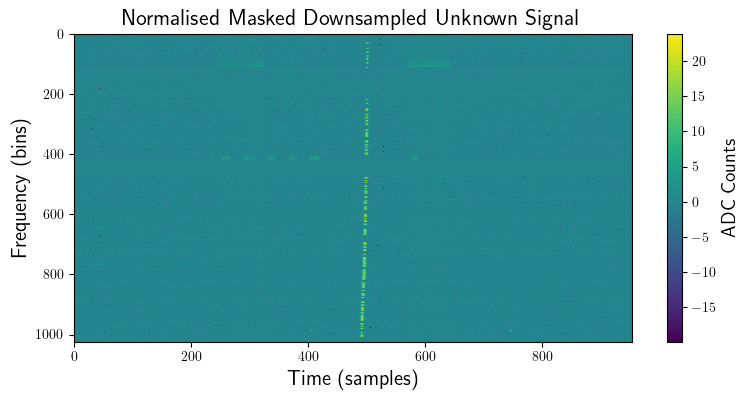

In [11]:
plot_imshow_transients(norm_data_masked_32.data, 
                       'Normalised Masked Downsampled Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [None, None], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       (None), #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

And so even without changing the scaling of the plot, there is a pulse clearly visible with a slight negative DM and a fairly broadband strength.

We can change the range data is plotted over to better look at the pulse signal. This will serve as a string suggestion of what range of parameters to search for our pulse over.

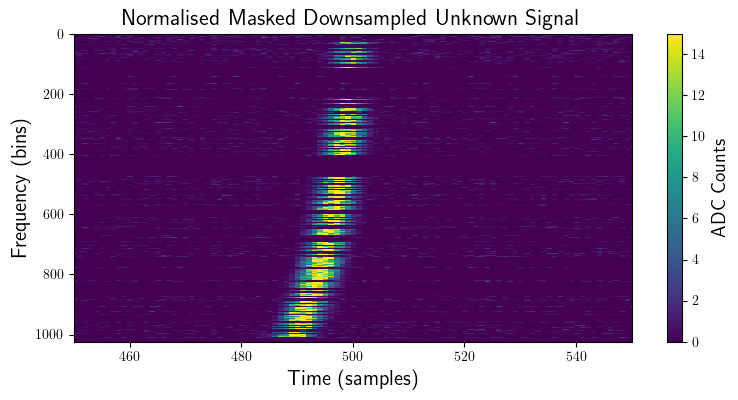

In [12]:
plot_imshow_transients(norm_data_masked_32.data, 
                       'Normalised Masked Downsampled Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [0, 15], #vmin, vmax
                       (450, 550), #xlim
                       (None), #ylim
                       (None), #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

#### De-dispersing

As a test of our anticipated model search parameters, we can hard-code a negative DM to dedisperse the data over to test what kind of dispersion the signal had at the time of observation. 

In [13]:
#using DM = -5.5 produces a fairly string signal like across frequencies.
norm_data_masked_32_ded = norm_data_masked_32.dedisperse(-5.5)

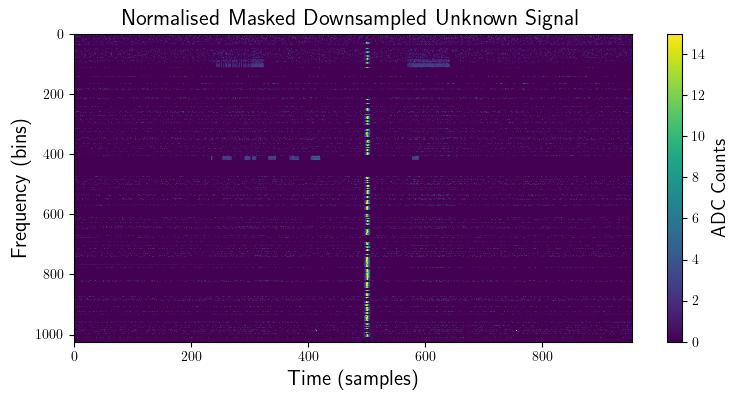

In [14]:
plot_imshow_transients(norm_data_masked_32_ded.data, 
                       'Normalised Masked Downsampled Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [0, 15], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       (None), #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

It's worth mentioning there are other features in the plot at particular frequencies and only lasting for various time samples. Since our search is for non-astrophysical signatures, these effects are not of particular interest in our current search and will hopefully be smoothed out by our matched filter search.

## Search for Unknown Signals

### Model Definition and Search Parameters

In order to search for unknown signals in our data we require some kind of model to try and describe a signal of interest with. Since our main goal is to search for extra-terrestial life, we anticipate that - under the assumption the intelligent life knows a similar level of astrophysics to us - the alien lifeforms will likely send out a signal that is not related to known astrophysical signatures. In other words, we would like to search our data set for signals containing a negative dispersion measure that are likely broad-band and a single pulse. Furthermore, a manufactured signal likely has a uniform spectral shape and is unlikely to be desribed well by a powerlaw spectrum. 

Under these assumptions, the best set of parameters to search for signals in our data are a combination of DMs and pulse widths. This search constitutes our assumed "model" of the data.

### Conducting the Search

In order to more easily feed the data to an algorithm and search for unknown signals, we can use the functions in the part3_funcs library to quickly process the data (perform rfi-excision and downsampling) along with reading in the filterbank objects.

Beginning with the blank sky, this will be our proxy for the "noise" in the signal data, and making use of our data preprocessing routines, we conduct the search below. 

In [15]:
#for the blank sky
blank_sky_masked_32_Fil = prepare_data('blank_sky', clean_rfi=True, downsample=True)
blank_sky_masked_32 = read_data(blank_sky_masked_32_Fil)
norm_blank_sky_masked_32 = blank_sky_masked_32.normalise()

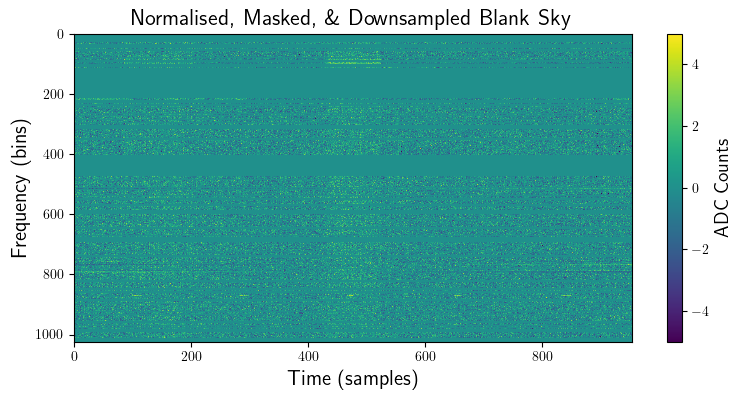

In [16]:
#visualizing the blank sky data set
plot_imshow_transients(norm_blank_sky_masked_32.data, 
                       'Normalised, Masked, \\& Downsampled Blank Sky',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [-5, 5], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       (None), #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

### Tests with injected signal

Before searching the real data set potentially containing an unknown signal, we can test out our algorithm using a data set containing an injected pulse with the following (known) characteristics:

- DM = -100
- width = 10ms
- SNR = 10 per freq bin

Beginning with the preprocessing..

In [17]:
#for the injected signal (abusing the variable names to avoid having to rewrite code..)
unknown_data_masked_32_Fil = prepare_data('data_w_injected_sig' , clean_rfi=True, downsample=True)
unknown_data_masked_32 = read_data(unknown_data_masked_32_Fil)
norm_data_masked_32 = unknown_data_masked_32.normalise()

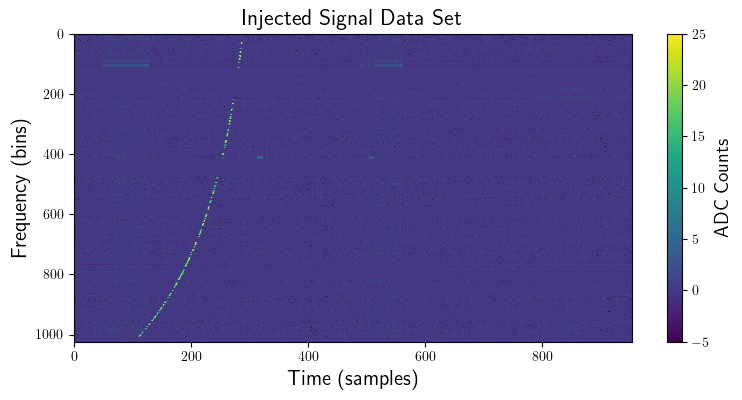

In [18]:
plot_imshow_transients(norm_data_masked_32.data, 
                       'Injected Signal Data Set',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [-5, 25], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       (None), #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

So, things seem to be working correctly in the sense that we can preprocess the data and produce a plot that reveals a single pulse signal with a large negative DM and small width.  

### Search Algorithm with Injected Known Pulse

Using the above plot to decide on the range of parameters to search over..

In [19]:
#assuming all rfi-excisiona and dedispersing has been completed
DM_range = np.linspace(-150, -50, 300)
width_range = np.linspace(0.04, 20, 300)
cand_threshold = 5

In [20]:
#use the parameter search algorithm to conduct the search for the SNR-maximizing params
DM_widths, max_DM, max_width = DM_width_search(norm_data_masked_32,
                            norm_blank_sky_masked_32,
                            DM_range,
                            width_range,
                            cand_threshold,
                            False
                            )

(300, 300)


In [21]:
print(f"The DM and pulse width that maximize the SNR are: {max_DM:.2f}pc cm^-3 and {1000*norm_data_masked_32.header.tsamp*max_width:.4f}ms")

The DM and pulse width that maximize the SNR are: -100.50pc cm^-3 and 11.6192ms


##### Plot the SNR heatmap to see how things converge.

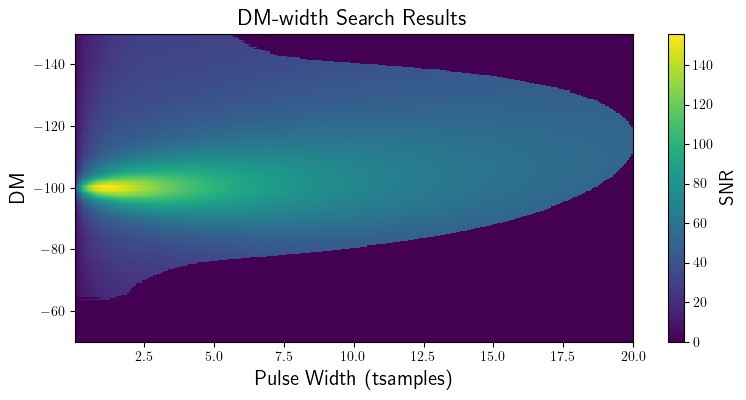

In [22]:
plot_imshow_transients(DM_widths, 
                       'DM-width Search Results',
                       'Pulse Width (tsamples)',
                       'DM',
                       'SNR',
                       [None, None], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       [width_range.min(), width_range.max(), DM_range.max(), DM_range.min()], #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

##### Plot the various time series and SNR plots.

We can use the associated class SignalPlotter to produce plots of

1. The dedispersed signal and blank sky
2. The dedispersed signal and blank sky convolved with the best fit Gaussian width
3. The SNR as a function of time and the associated histogram for the best fit DM and width pair 

In [23]:
signal_plots = SignalPlotter(norm_data_masked_32, norm_blank_sky_masked_32, max_DM, max_width, norm=False)

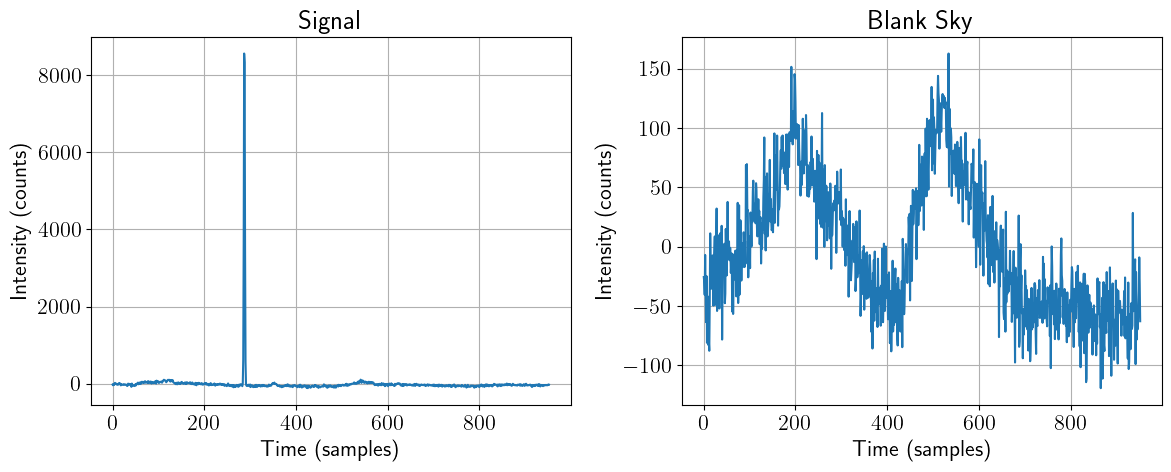

In [24]:
#plot the initial dedispersed time series 
signal_plots.plot_original_time_series()

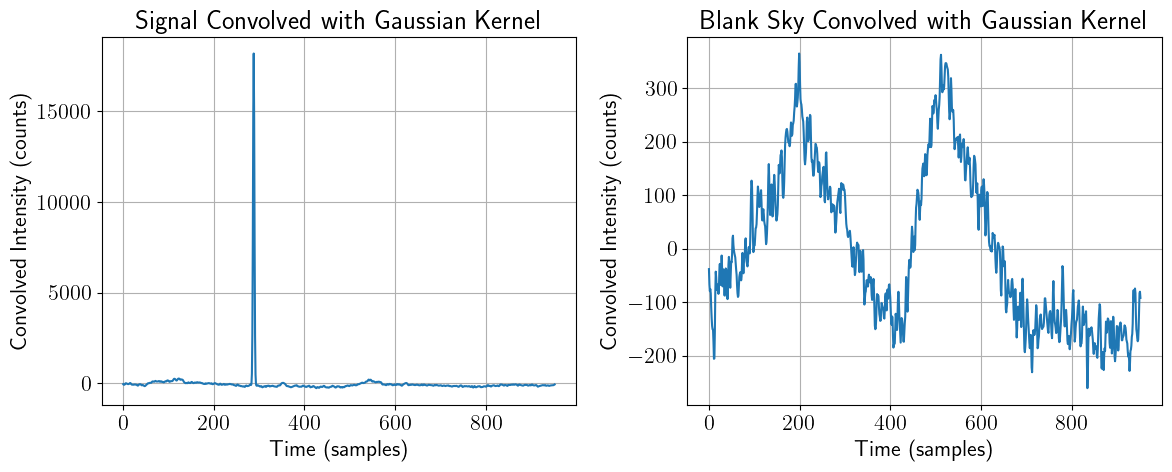

In [25]:
#plot convolved time series
signal_plots.plot_convolved_time_series()

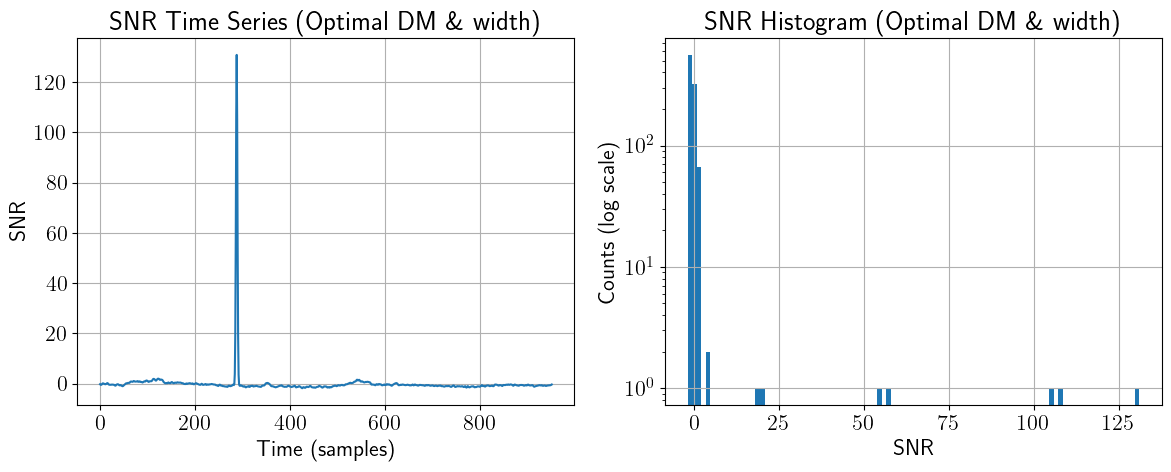

In [26]:
#plot SNR results
signal_plots.plot_snr(use_log_scale=True)

#### Final Dedispersed Signal Time Series

As a final step, we can convert the signal found at the optimal DM to units of Jansky's.

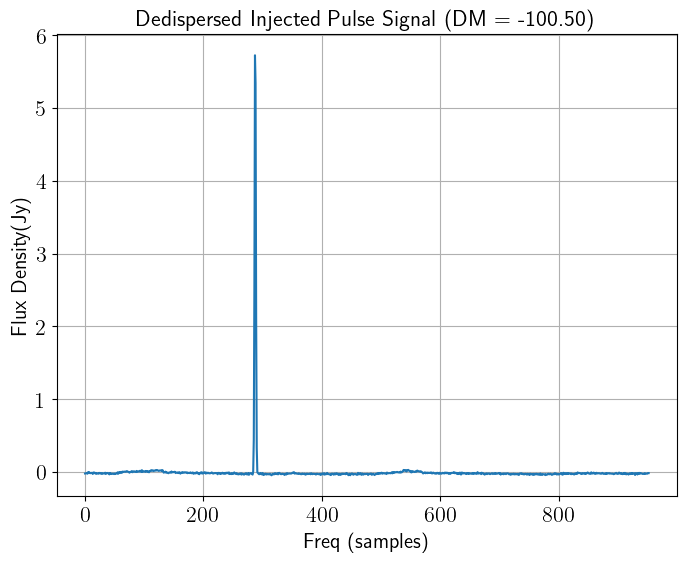

In [27]:
#load in the transfer function
transfer_function = np.load('transfer_function.npy')

#plot the dedispersed pulse
signal_plots.plot_calibrated_pulse(transfer_function, f'Dedispersed Injected Pulse Signal (DM = {max_DM:.2f})')

Examining the results above, we can see that the algorithm gets pretty close to those characterizing the injected pulse, meaning it is likely safe to apply this search routine to the data set potentially containing an unknown signal.

### Searching the Unknown Data Set

In this part, we repeat the above analysis, but instead use the data set visualized in the first section that seemed to possess a single broadband pulse with a small DM and pulse width.

#### Data preprocessing and visualizing

In [28]:
#for the injected signal (abusing the variable names to avoid having to rewrite code..)
unknown_data_masked_32_Fil = prepare_data('data_261084068' , clean_rfi=True, downsample=True)
unknown_data_masked_32 = read_data(unknown_data_masked_32_Fil)
norm_data_masked_32 = unknown_data_masked_32.normalise()

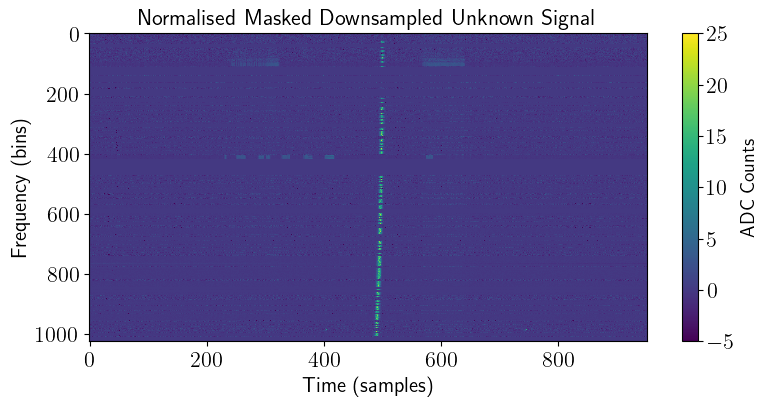

In [29]:
plot_imshow_transients(norm_data_masked_32.data, 
                       'Normalised Masked Downsampled Unknown Signal',
                       'Time (samples)',
                       'Frequency (bins)',
                       'ADC Counts',
                       [-5, 25], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       (None), #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

#### Search Algorithm with Unknown Pulse Signature

Modifying the search parameters slightly - we can make a good guess at these since it is straight forward to see the signal in the waterfall plot.

In [30]:
#assuming all rfi-excisiona and dedispersing has been completed
DM_range = np.linspace(-30, -1, 300)
width_range = np.linspace(0.02, 20, 300)
cand_threshold = 4

In [31]:
DM_widths, max_DM, max_width = DM_width_search(norm_data_masked_32,
                            norm_blank_sky_masked_32,
                            DM_range,
                            width_range,
                            cand_threshold,
                            False
                            )

(300, 300)


In [32]:
print(max_width)

2.1583277591973244


In [33]:
print(f"The DM and pulse width that maximize the SNR are: {max_DM:.2f}pc cm^-3 and {1000*norm_data_masked_32.header.tsamp*max_width:.4f}ms")

The DM and pulse width that maximize the SNR are: -6.53pc cm^-3 and 22.6317ms


##### Plot the SNR heatmap to see how things converge.

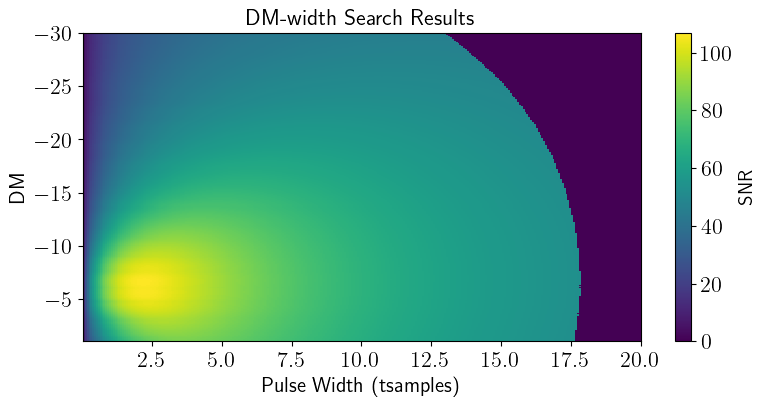

In [34]:
plot_imshow_transients(DM_widths, 
                       'DM-width Search Results',
                       'Pulse Width (tsamples)',
                       'DM',
                       'SNR',
                       [None, None], #vmin, vmax
                       (None), #xlim
                       (None), #ylim
                       [width_range.min(), width_range.max(), DM_range.max(), DM_range.min()], #extent ie. [..,.., etc..]
                       (9, 4),
                       16,
                       False)

##### Plotting the various time series and SNR plots.

In [35]:
signal_plots = SignalPlotter(norm_data_masked_32, norm_blank_sky_masked_32, max_DM, max_width, norm=False)

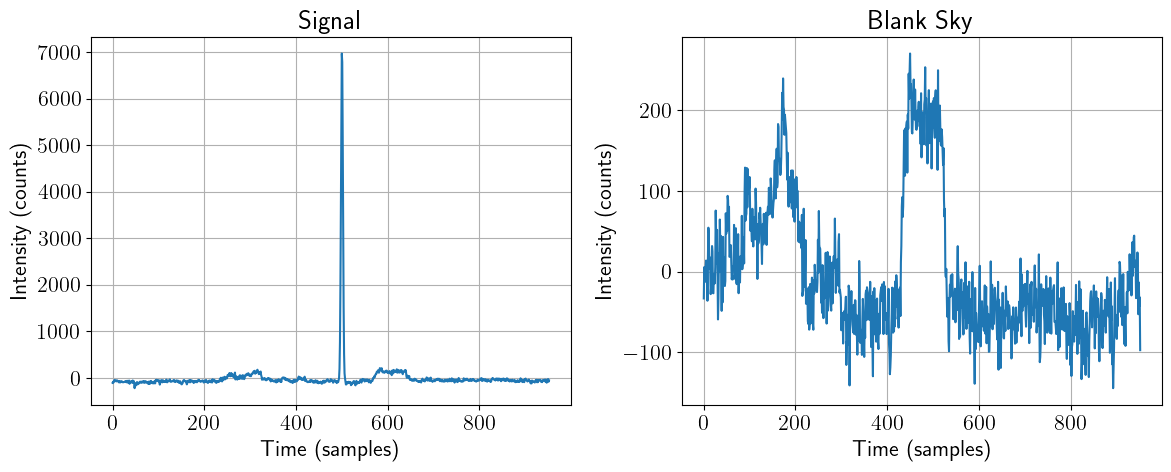

In [36]:
#plot the initial dedispersed time series 
signal_plots.plot_original_time_series()

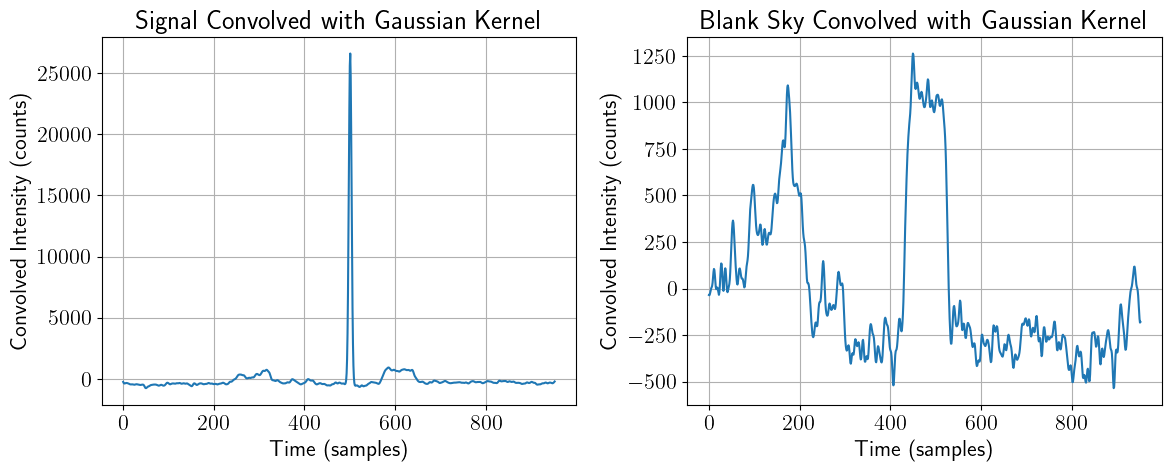

In [37]:
#plot convolved time series
signal_plots.plot_convolved_time_series()

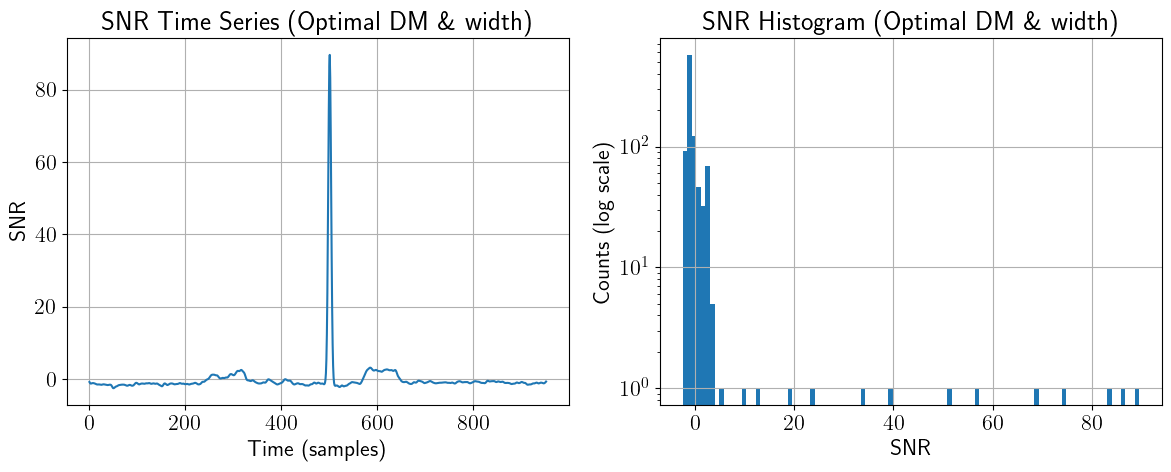

In [38]:
#plot SNR results
signal_plots.plot_snr(use_log_scale=True)

#### Final Dedispersed (Unknown) Signal Time Series

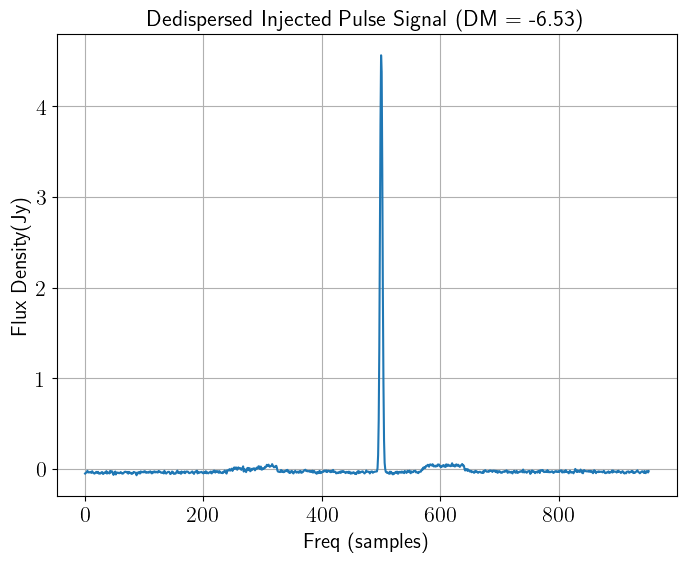

In [39]:
#load in the transfer function
transfer_function = np.load('transfer_function.npy')

#plot the dedispersed pulse
signal_plots.plot_calibrated_pulse(transfer_function, f'Dedispersed Injected Pulse Signal (DM = {max_DM:.2f})')

### Model Fit Significance

The results of applying the matched filter search algorithm to the unknown data set show a strong SNR for the paramters DM $\sim$ -6 and width $\sim$ 23ms, demonstrating a clearly defined, broadband, short, pulse-like signal with small negative DM as was clearly visualized in the initial exploration section. 

The negative DM is indicative of a signal that is not (as we know of) astrophysical in origin, though the specific DM of $\sim$ -6 does not necessarily provide the ability to say with some certainty the distance with which this signal originated. The reason is that we don't know with what DM the signal originated with. We may choose to say that any sentient and intelligent life living in the Milky way would choose to send a pulse such that the farthest obects bound to the Milky Way would still observe the signal to have a negative DM by the time it has reached them. Under this assumption, and although this would highly depend on the direction of propagation (ie. through the disk of the MW for example), the signal may have been sent with a negative dispersion of atleast 1000 pc cm $^{-3}$ implying lifeforms of the order of 10 kpc away.

This argument is highly speculative and depends on both the column density along the line of sight to the source origin and the specific DM that the signal may have been sent with. However, we can say with some level of certainty given our signal to noise plots, that we have indeed detected a signal at greater than roughly 90 $\sigma$ under the null hypothesis that the result is noise. This is a highly significant result and shows that we found a signal with the DM and width parameters mentioned previously with extremely high probability.